# Model Evaluation

Applying machine learning in an applied science context is often method work. We build a prototype model and expect want to show that this method can be applied to our specific problem. This means that we have to guarantee that the insights we glean from this application generalize to new data from the same problem set.

This is why we usually import `train_test_split()` from scikit-learn to get a validation set and a test set. But in my experience, in real-world applications, this isn’t always enough. In science, we usually deal with data that has some kind of correlation in some kind of dimension. Sometimes we have geospatial data and have to account for Tobler’s Law, i.e. things that are closer to each other matter more to each other than those data points at a larger distance. Sometimes we have temporal correlations, dealing with time series, where data points closer in time may influence each other.

Not taking care of proper validation, will often lead to additional review cycles in a paper submission. It might lead to a rejection of the manuscript which is bad enough. In the worst case scenario, our research might report incorrect conclusions and have to be retracted. No one wants rejections or even retractions.

So we’ll go into some methods to properly evaluate machine learning models even when our data is not “independent and identically distributed”.

In [1]:
from pathlib import Path

DATA_FOLDER = Path("..") / "data"
DATA_FILEPATH = DATA_FOLDER / "penguins_clean.csv"

In [2]:
import pandas as pd
penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Species
0,39.1,18.7,181.0,MALE,Adelie Penguin (Pygoscelis adeliae)
1,39.5,17.4,186.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
2,40.3,18.0,195.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
3,36.7,19.3,193.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
4,39.3,20.6,190.0,MALE,Adelie Penguin (Pygoscelis adeliae)


## Data Splitting 
The simplest method of splitting data into a training and test data set is `train_test_split()`, which randomly selects samples from our dataframe. 

This method essentially makes a very big assumption. That assumption being that our data is "independent and identically distributed" or i.i.d..

That simply means that each measurement for a penguin does not depend on another measurement. Luckily for penguins that is mostly true. For other data? Not so much.
And it means that we expect that we have a similar distribution of measurements of our penguins to the unseen data or future measurements.

<div class="alert alert-block alert-info">
<b>Tip:</b> The i.i.d. assumption lies at the core of most machine learning and is an important concept to dive into and understand.</div>

In [3]:
from sklearn.model_selection import train_test_split
num_features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)"]
cat_features = ["Sex"]
features = num_features + cat_features
target = ["Species"]

X_train, X_test, y_train, y_test = train_test_split(penguins[features], penguins[target], train_size=.7, random_state=42)
X_train

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex
284,46.4,18.6,190.0,FEMALE
294,46.4,17.8,191.0,FEMALE
56,37.6,17.0,185.0,FEMALE
175,47.3,15.3,222.0,MALE
10,36.6,17.8,185.0,FEMALE
...,...,...,...,...
188,49.6,15.0,216.0,MALE
71,37.2,19.4,184.0,MALE
106,39.7,17.7,193.0,FEMALE
270,52.7,19.8,197.0,MALE


## Stratification 
Usually, our target class or another feature we use isn't distributed equally.

In [4]:
from matplotlib import pyplot as plt

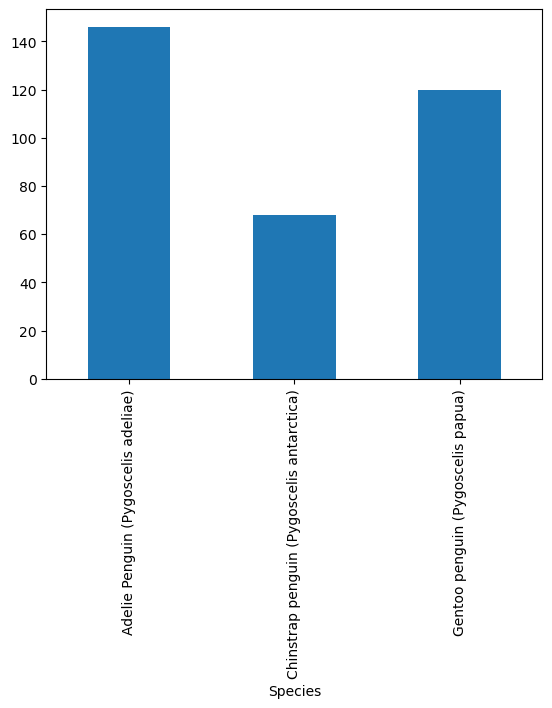

In [5]:
penguins.groupby("Species").Sex.count().plot(kind="bar")
plt.show()

In this case it's not very extreme. We have around twice as many Adelie than Chinstrap penguins.

However, this can mean that we accidentally have almost no Chinstrap penguins in our training data, as it randomly overselects Adelie penguins.

In [6]:
y_train.reset_index().groupby(["Species"]).count()

,index
Species,
Adelie Penguin (Pygoscelis adeliae),97
Chinstrap penguin (Pygoscelis antarctica),46
Gentoo penguin (Pygoscelis papua),90


We can address this by applying **stratification**.

That is simply achieved by randomly sampling *within a class** (or strata) rather than randomly sampling from the entire dataframe.

In [7]:
X, y = penguins[features], penguins[target[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42, stratify=y)

To qualitatevely assess the effect of stratification, let's plot class distribution in both _training_ and _test_ sets:

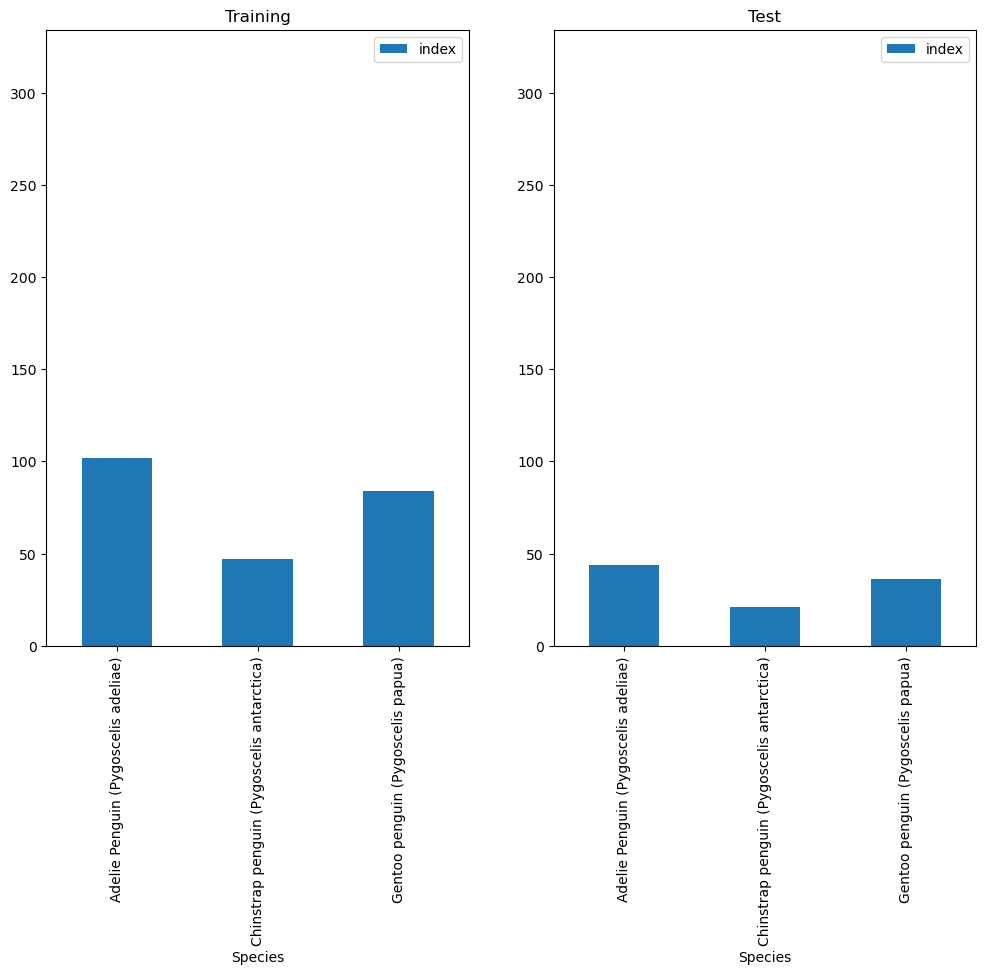

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

y_train.reset_index().groupby("Species").count().plot(kind="bar", ax=ax1, ylim=(0, len(y)), title="Training")
y_test.reset_index().groupby("Species").count().plot(kind="bar", ax=ax2, ylim=(0, len(y)), title="Test")
plt.show()

Let's quickly train a model to evaluate

In [9]:
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC()),
])

This difference is not drastic, as we can see in the plot above.
That changes however, when we have minority classes with much less data than the majority class.

Either way it's worth it to keep in mind that stratification exists. The `stratify=` keyword takes any type of vector as long as it matches the dimension of the dataframe.

## Cross-Validation
Cross-validation is often considered the gold standard in statistical applications and machine learning.

Cross-validation splits the data into folds, of which one is held out as the validation set and the rest is used to train.
Subsequently, models are trained on the other folds in a round-robin style. That way we have models that are trained and evaluated on every sample of the dataset.
![Scikit-learn cross validation](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)
*Scikit-learn cross-validation schema. [[Source](https://scikit-learn.org/stable/modules/cross_validation.html)]*

Cross-validation is particularly useful when we don't have a lot of data or the data is highly heterogeneous.

In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([1.        , 1.        , 0.9787234 , 0.97826087, 0.97826087])

In [11]:
print(f"{scores.mean():0.2f} accuracy with a standard deviation of {scores.std():0.2f}")

0.99 accuracy with a standard deviation of 0.01


Now we know there are some folds this support-vector machine will do exceptional on and others it does quite well on only getting a few samples wrong.

## Model Evaluation

Brilliant! So let's recap for a moment what we have done so far, in preparation for our (final) **Model evaluation**.

We have:

- prepared the model pipeline: `sklearn.pipeline.Pipeline` with `preprocessor + model`
- generated **train** and **test** data partitions (with stratification): `(X_train, y_train)` and `(X_test, y_test)`, respectively
    - stratification guaranteed that those partitions will retain class distributions
- assessed model performance via **cross validation** (i.e. `cross_val_score`) on `X_train`(!!)
    - this had the objective of verifying model consistency on multiple data partitioning

Now we need the complete our last step, namely "assess how the model we chose in CV" (we only had one model, so that was an easy choice :D ) will perform on _future data_!
And we have a _candidate_ as representative for these data: `X_test`.

Please note that `X_test` has never been used so far (as it should have!). The take away message here is: _generate test partition, and forget about it until the last step!_


Thanks to `CV`, We have an indication of how the `SVC` classifier behaves on multiple "version" of the training set. We calculated an average score of `0.99` accuracy, therefore we decided this model is to be trusted for predictions on _unseen data_.

Now all we need to do, is to prove this assertion.

To do so we need to: 
    - train a new model on the entire **training set**
    - evaluate it's performance on **test set** (using the metric of choice - presumably the same metric we chose in CV!)

In [12]:
# training
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC()),
])
classifier = model.fit(X_train, y_train)

In [13]:
# Model evaluation
from sklearn.metrics import accuracy_score

y_pred = classifier.predict(X_test)
print("TEST ACC: ", accuracy_score(y_true=y_test, y_pred=y_pred))

TEST ACC:  1.0


Now we can finally say that we have concluded our model evaluation - with a fantastic score of `0.96` Accuracy on the test set.

## Choosing the appropriate Evaluation Metric

Ok, now for the mere sake of considering a more realistic data scenario, let's pretend our reference dataset is composed by only samples from two (out of the three) classes we have. In particular, we will crafting our dataset by choosing the most and the least represented classes, respectively. 

The very idea is to explore whether the choice of appropriate metrics could make the difference in our machine learning models evaluation.

Let's recall class distributions in our dataset:

In [14]:
y.reset_index().groupby(["Species"]).count()

,index
Species,
Adelie Penguin (Pygoscelis adeliae),146
Chinstrap penguin (Pygoscelis antarctica),68
Gentoo penguin (Pygoscelis papua),120


So let's select samples from the first two classes, `Adelie Penguin` and `Chinstrap penguin`:

In [15]:
samples = penguins[((penguins["Species"].str.startswith("Adelie")) | (penguins["Species"].str.startswith("Chinstrap")))]

In [16]:
samples.shape[0] == 146 + 68 # quick verification

True

To make things even harder for our machine learning model, let's also see if we could get rid of _clearly_ separating features in this toy dataset

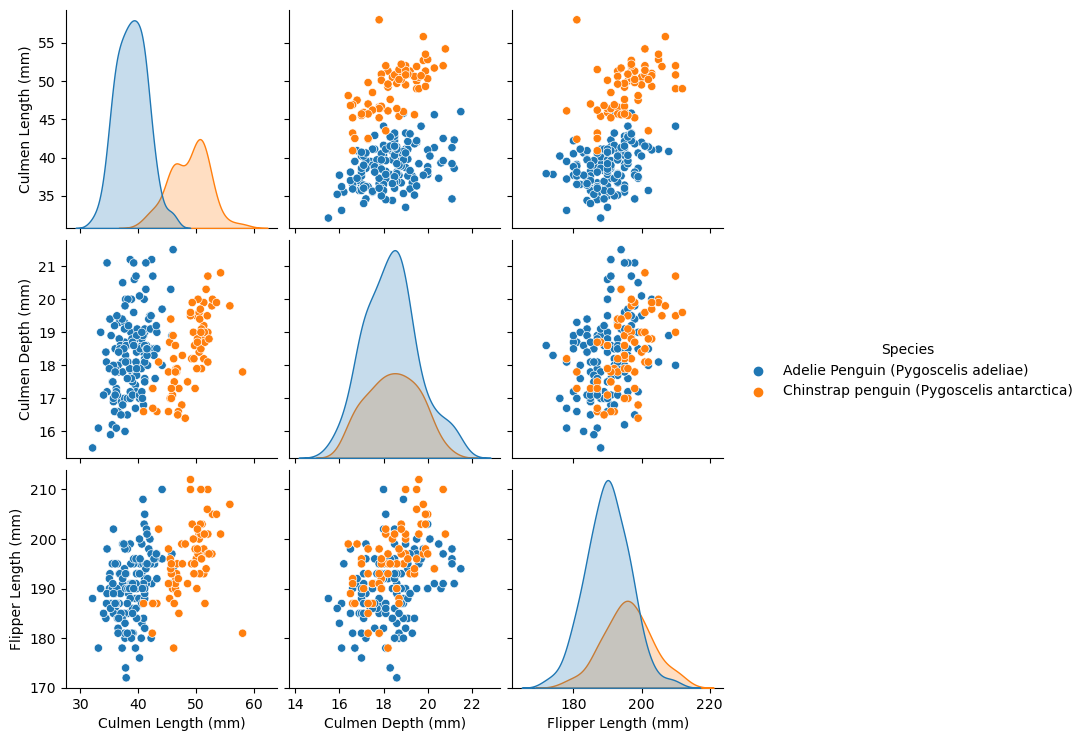

In [17]:
import seaborn as sns

pairplot_figure = sns.pairplot(samples, hue="Species")

OK so if we get to choose, we could definitely say that in this dataset, the `Flipper Length` in combination with the `Culmen Depth` leads to the hardest classification task for our machine learning model.

Therefore, here is the plan:
- we select only those to numerical features (_iow_ we will get rid of the `Culmen Lenght` feature)
- we will apply an identical _Model evaluation_ pipeline as we did in our previous example
    - Cross Validation + Evaluation on Test set

The very difference this time is that we will use multiple metrics to evaluate our model to prove our point on _carefully selecting evaluation metrics_.

In [18]:
num_features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)"]
selected_num_features = num_features[1:]
cat_features = ["Sex"]
features = selected_num_features + cat_features

In [19]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, selected_num_features),  # note here, we will only preprocess selected numerical features
    ('cat', cat_transformer, cat_features)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC()),
])

In [20]:
X, y = samples[features], samples[target[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42, stratify=y)  # we also stratify on classes

In [21]:
y_train.reset_index().groupby("Species").count()

,index
Species,
Adelie Penguin (Pygoscelis adeliae),102
Chinstrap penguin (Pygoscelis antarctica),47


In [22]:
y_test.reset_index().groupby("Species").count()

,index
Species,
Adelie Penguin (Pygoscelis adeliae),44
Chinstrap penguin (Pygoscelis antarctica),21


In our evaluation pipeline we will be using keep record both **accuracy** (`ACC`) and **matthew correlation coefficient** (`MCC`)

In [23]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import accuracy_score as acc

mcc_scorer = make_scorer(mcc)
acc_scorer = make_scorer(acc)
scores = cross_validate(model, X_train, y_train, cv=5,
                        scoring={"MCC": mcc_scorer, "ACC": acc_scorer})
scores

{'fit_time': array([0.00280213, 0.00202894, 0.00185108, 0.00180268, 0.00207806]),
 'score_time': array([0.00152302, 0.00129795, 0.00125003, 0.00143123, 0.00151396]),
 'test_MCC': array([0.37796447, 0.27863911, 0.40824829, 0.02424643, 0.08625819]),
 'test_ACC': array([0.73333333, 0.7       , 0.76666667, 0.66666667, 0.62068966])}

In [24]:
import numpy as np

print("Avg ACC in CV: ", np.average(scores["test_ACC"]))
print("Avg MCC in CV: ", np.average(scores["test_MCC"]))

Avg ACC in CV:  0.697471264367816
Avg MCC in CV:  0.2350712993854009


In [25]:
model = model.fit(X_train, y_train)

print("ACC: ", acc_scorer(model, X_test, y_test))
print("MCC: ", mcc_scorer(model, X_test, y_test))

ACC:  0.7230769230769231
MCC:  0.29439815585406465


To see exactly what happened, let's have a look at the **Confusion matrix**

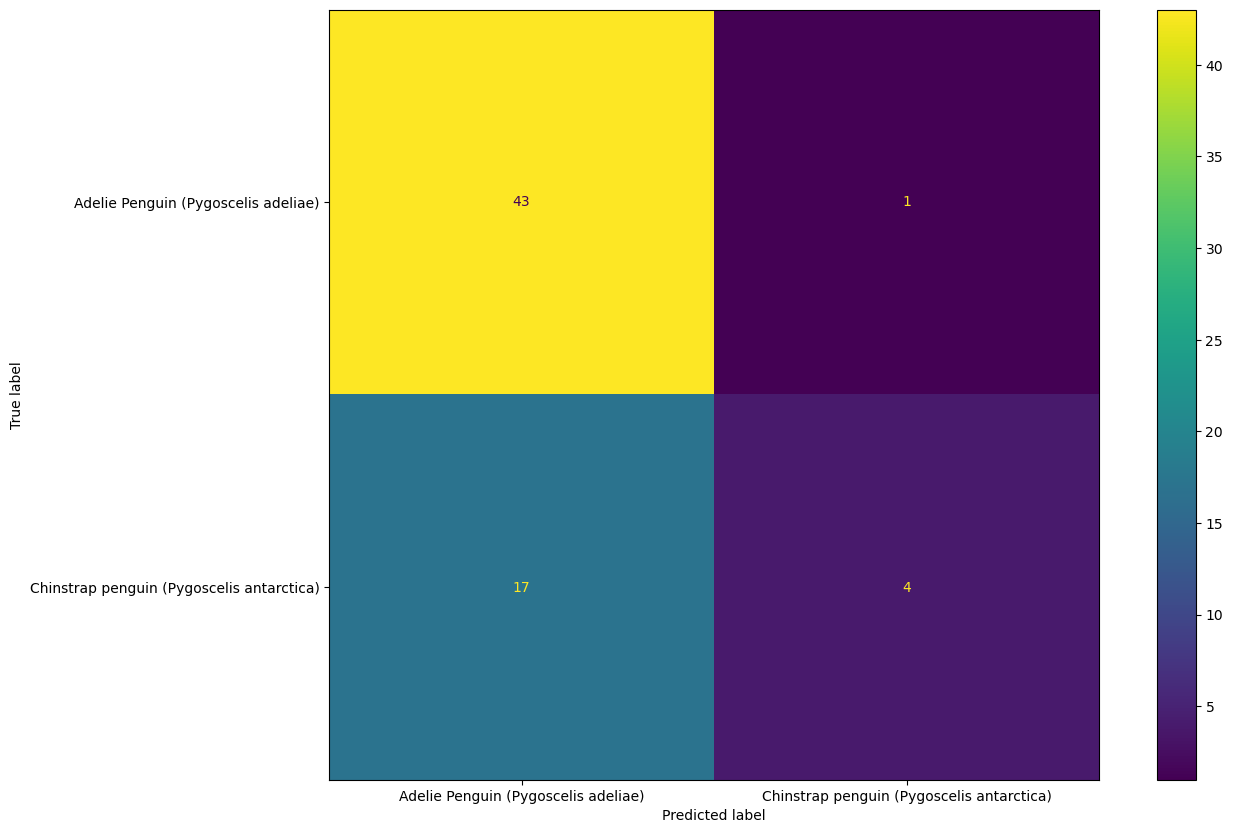

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(15, 10))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)
plt.show()

As expected, the model did a pretty bad job in classifying *Chinstrap Penguins* and the `MCC` was able to catch that, whilst `ACC` could not as it only considers correctly classified samples!

## Time-series Validation

But validation can get tricky if time gets involved.

Imagine we measured the growth of baby penguin Hank over time and wanted to us machine learning to project the development of Hank. Then our data suddenly isn't i.i.d. anymore, since it is dependent in the time dimension.

Were we to split our data randomly for our training and test set, we would test on data points that lie in between training points, where even a simple linear interpolation can do a fairly decent job.

Therefor, we need to split our measurements along the time axis
![Scikit-learn time series validation](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)
*Scikit-learn Time Series CV [[Source]](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split).*

In [27]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)

for train, test in tscv.split(X):
    print("%s %s" % (train, test))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


## Spatial Validation

Spatial data, like maps and satellite data has a similar problem.

Here the data is correlated in the spatial dimension. However, we can mitigate the effect by supplying a group. In this simple example I used continents, but it's possible to group by bins on a lat-lon grid as well. 

Here especially, a cross-validation scheme is very important, as it is used to validate against every area on your map at least once.

In [28]:
from sklearn.model_selection import GroupKFold

X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 0.001]
y = [1, 2, 4, 2, 2, 3, 4, 5]
groups = ["Europe", "Africa", "Africa", "Africa", "America", "Asia", "Asia", "Europe"]
cv = GroupKFold(n_splits=4)
for train, test in cv.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[0 4 5 6 7] [1 2 3]
[1 2 3 4 5 6] [0 7]
[0 1 2 3 4 7] [5 6]
[0 1 2 3 5 6 7] [4]


## Conclusion

A simple random split of the data works on toy problems, but real-world data is rarely i.i.d.

We looked at different ways that we can evaluate models that violate the i.i.d. assumption and how we can still evaluate their performance on unseen data without obtaining artificially high scores.


<div class="alert alert-block alert-info">
<b>Tip:</b> Artificially high scores from leakage and cheating mean that our scientific finding hold no merit. This is often caught in review and prolongs the review process (which no one wants). But in the worst case can lead to diverting research funds in a wrong direction and paper redactions / corrections.</div>